# Effects of changing the LJ radius
And general sanity checks on the LJ reconstruction choices

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

In [2]:
samples = [
    "2Mu2E_100GeV_1p2GeV_9p6mm"
]
fileset = utilities.make_fileset(samples, "ffntuple_v4")

Run the processor with several lj_reco choices.

In [3]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
)

p = sidm_processor.SidmProcessor(
    [
    "pvAndCosmic_cuts",
    "baseNoLj",
    ],
    ["base_plus_gen"],
    #-0.4 means use the ljsource collection to cluster jets with radius 0.4, 
    # 0 means use the lepton jets directly from the ntuples
    # Any other positive number is the radius of the jet. 
    lj_reco_choices=["0","-0.1","0.1","-0.6","0.6","-0.4","0.4","-0.2","0.2","-0.05","0.05","0.01","0.005"],
    unweighted_hist=True
)

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]["2Mu2E_100GeV_1p2GeV_9p6mm"]
reco_eff = out["counters"]
hists = out["hists"]

Output()

Output()

Not applying any cuts to the lepton jets for channel  pvAndCosmic_cuts
Not applying any cuts to the lepton jets for channel  baseNoLj
#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#------------

## Efficiency of lepton-jet reconstruction

Use the "counters" object to look at number of dark photons decaying to electrons or muons that end up matched to a lepton jet.

In [4]:
channel = "baseNoLj"
print(channel)
print("LJ Reco   Total reco LJs    TotalAsToMu  MatchedMu   TotalEle    MatchedEle")

radii = ["0","0.6","0.4","0.2","0.1","0.05","0.01","0.005","-0.6","-0.4","-0.2","-0.1","-0.05"]
for lj_reco in radii:

    effs = reco_eff[lj_reco][channel]    
    print(lj_reco,"     ",effs["Total LJs"],"          ",effs["Gen As to muons"],"        ",effs["Matched gen As to muons"],"      ",
              effs["Gen As to electrons"],"     ",effs["Matched gen As to electrons"])


baseNoLj
LJ Reco   Total reco LJs    TotalAsToMu  MatchedMu   TotalEle    MatchedEle
0       3373786            30013          19931        30013       7065
0.6       879450            30013          29151        30013       8183
0.4       880725            30013          29154        30013       8183
0.2       889695            30013          29154        30013       8183
0.1       953790            30013          29154        30013       8183
0.05       1141485            30013          29154        30013       8183
0.01       1225305            30013          29154        30013       8183
0.005       1226880            30013          29154        30013       8183
-0.6       877690            30013          29151        30013       8108
-0.4       878950            30013          29154        30013       8108
-0.2       887920            30013          29154        30013       8108
-0.1       952015            30013          29154        30013       8108
-0.05       1139695          

The efficiency doesn't really change with the radius, but as I show below, the radius is actually having an effect. We still reconstruct a lepton jet, but at lower radii there is only a single constituent per LJ. (That's why the total number of reconstructed lepton jets goes up)

The efficiency will be impacted more once we apply cuts on muon_n and other cosmic veto cuts.

### Comparing ntuple ljs to using the ljsource collection
-0.4 should give us approximately the same number of lepton jets as using 0 (the default collection), except 0 has extra cuts.
We should always expect the number of LJs reconstructed with 0 to be *less* than the number reconstructed with 0.4

To exactly match, we would need to apply the cosmic veto cuts to the muon LJs, which we haven't done yet.

In [5]:
channel = "baseNoLj"
print(channel)

for lj_reco in ["0","-0.4"]:
    effs =reco_eff[lj_reco][channel]    

    total = effs["Gen As to muons"] + effs["Gen As to electrons"]
    total_matched = effs["Matched gen As to muons"] + effs["Matched gen As to electrons"]
    total_eff = total_matched/total
    print("Overall efficiency for ",lj_reco,", ",channel,": ", total_eff, 
          " (Muons: ",effs["Matched gen As to muons"]/effs["Gen As to muons"],
          ", electrons: ",effs["Matched gen As to electrons"]/effs["Gen As to electrons"],")")

baseNoLj
Overall efficiency for  0 ,  baseNoLj :  0.4497384466731083  (Muons:  0.6640788991437044 , electrons:  0.23539799420251226 )
Overall efficiency for  -0.4 ,  baseNoLj :  0.6207643354546363  (Muons:  0.9713790690700697 , electrons:  0.270149601839203 )


## Comparing dRSpread and number of constituents

For reference, here is what the di-lepton dR distribution looks like for this sample. Most leptons are within 0.2 of each other.

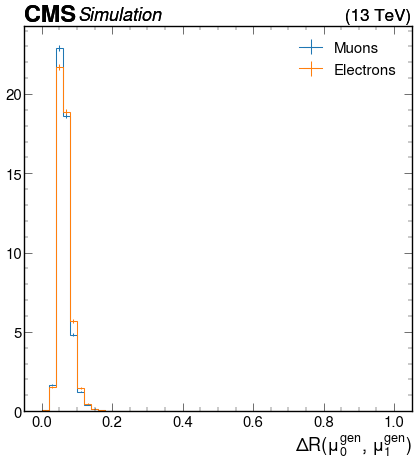

In [6]:
utilities.plot(hists["genMu_genMu_dR"]["0","baseNoLj", :],label="Muons",density=True)
utilities.plot(hists["genE_genE_dR"]["0","baseNoLj", :],label="Electrons",density=True)

plt.legend()

Compare the dRSpread for different samples. I'm not sure how this is calculated for the lepton jets in the ntuples, but for the LJs we cluster, this is the maximum dR between any pair of constituents in the LJ. 

Notice that the peak at 0 corresponds to lepton jets with only one constituent. As we decrease the jet radius, we get more lepton "jets" which are just a single object.

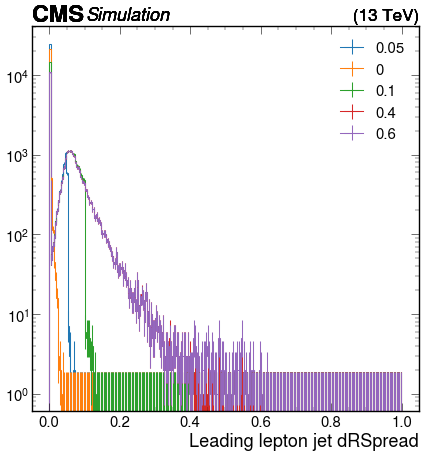

In [7]:
channel="baseNoLj"
hist = "lj0_dRSpread"
# utilities.plot(hists[hist]["0.01",channel, :],label="0.01")
utilities.plot(hists[hist]["0.05",channel, :],label="0.05")
utilities.plot(hists[hist]["0",channel, :],label="0")
utilities.plot(hists[hist]["0.1",channel, :],label="0.1")
# utilities.plot(hists[hist]["-0.4",channel, :],label="-0.4")
utilities.plot(hists[hist]["0.4",channel, :],label="0.4")
utilities.plot(hists[hist]["0.6",channel, :],label="0.6")
# utilities.plot(out[dataset]["hists"]["lj0_dRSpread"]["-0.6",channel, :],label="-0.6")

plt.yscale("log")

plt.legend()

We can see this switch from 2-constituents to 1 constituent especially for the muons. Notice that we are *not* applying cut on muon_n yet. For the LJs from the ntuples, we only keep muon LJs with an *even* number of muons.

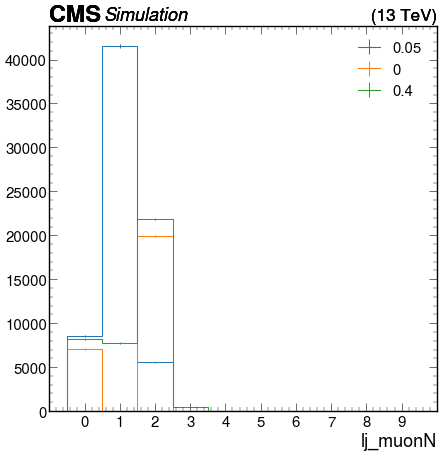

In [8]:
channel="baseNoLj"
hist = "lj_muonN"
# utilities.plot(hists[hist]["0.01",channel, :],label="0.01")
utilities.plot(hists[hist]["0.05",channel, :],label="0.05")
utilities.plot(hists[hist]["0",channel, :],label="0")
#utilities.plot(hists[hist]["0.1",channel, :],label="0.1")
# utilities.plot(hists[hist]["-0.4",channel, :],label="-0.4")
utilities.plot(hists[hist]["0.4",channel, :],label="0.4")
#utilities.plot(hists[hist]["0.6",channel, :],label="0.6")
# utilities.plot(out[dataset]["hists"]["lj0_dRSpread"]["-0.6",channel, :],label="-0.6")

#plt.yscale("log")

plt.legend()

The effect from 2 to 1 constituents is smaller for egm: (not really visible unless you look in log scale)

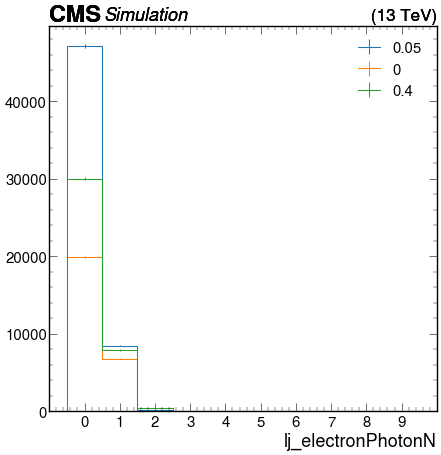

In [9]:
channel="baseNoLj"
hist = "lj_electronPhotonN"
# utilities.plot(hists[hist]["0.01",channel, :],label="0.01")
utilities.plot(hists[hist]["0.05",channel, :],label="0.05")
utilities.plot(hists[hist]["0",channel, :],label="0")
#utilities.plot(hists[hist]["0.1",channel, :],label="0.1")
# utilities.plot(hists[hist]["-0.4",channel, :],label="-0.4")
utilities.plot(hists[hist]["0.4",channel, :],label="0.4")
#utilities.plot(hists[hist]["0.6",channel, :],label="0.6")
# utilities.plot(out[dataset]["hists"]["lj0_dRSpread"]["-0.6",channel, :],label="-0.6")

#plt.yscale("log")

plt.legend()

## Other possibly useful distributions

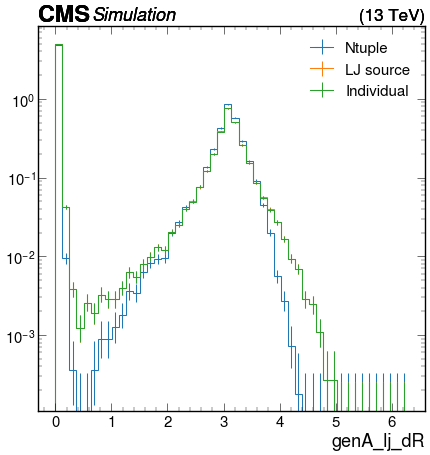

In [10]:
utilities.plot(hists["genA_lj_dR"]["0","baseNoLj",:],density=True,label="Ntuple")
utilities.plot(hists["genA_lj_dR"]["-0.4","baseNoLj",:],density=True,label="LJ source")
utilities.plot(hists["genA_lj_dR"]["0.4","baseNoLj",:],density=True,label="Individual")
plt.yscale("log")
plt.legend()

The plot below is for a radius of 0.4. Most of the reconstructed lepton jets are at very low energy.

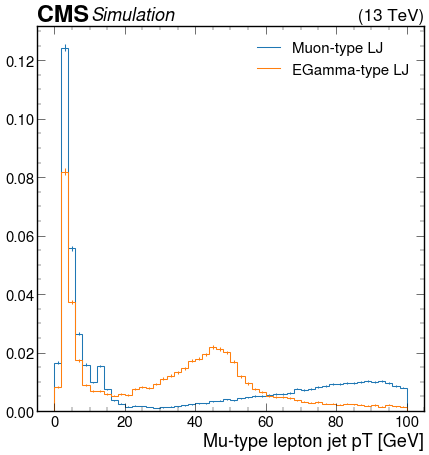

In [11]:
utilities.plot([
   hists["mu_lj_pt"]["0.4","pvAndCosmic_cuts", ::2j],
   hists["egm_lj_pt"]["0.4","pvAndCosmic_cuts", ::2j],
],density=True)
plt.legend(["Muon-type LJ", "EGamma-type LJ"])